In [1]:
import numpy as np
import nltk
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from conllu import parse, parse_tree #using the conllu for parsing (pip install conllu)

In [2]:
# the corpus I am suggesting is from https://deep-sequoia.inria.fr/versions/
corpus = nltk.corpus.reader.plaintext.PlaintextCorpusReader(".", "sequoia-8.1/sequoia.deep.conll")
data = re.sub(r" +", r"\t", corpus.raw())
sentences = parse(data)

The corpus contains 3099 sentences.

Number of sentences for each sub-domain :
- 561 sentences	Europarl	 file= Europar.550+fct.mrg
- 529 sentences	EstRepublicain   file= annodis.er+fct.mrg
- 996 sentences	French Wikipedia file= frwiki_50.1000+fct.mrg
- 574 sentences	EMEA (dev)  	 file= emea-fr-dev+fct.mrg
- 544 sentences	EMEA (test) 	 file= emea-fr-test+fct.mrg, among which 101 were removed (because duplicates) in surface version 6.0 and 1.0 deep version.

In [3]:
#a preview of every sentence
sentences[1]

[OrderedDict([('id', 1),
              ('form', 'Cette'),
              ('lemma', 'ce'),
              ('upostag', 'D'),
              ('xpostag', 'DET'),
              ('feats', OrderedDict([('g', 'f'), ('n', 's'), ('s', 'dem')])),
              ('head', 2),
              ('deprel', 'det'),
              ('deps', None),
              ('misc', None)]),
 OrderedDict([('id', 2),
              ('form', 'exposition'),
              ('lemma', 'exposition'),
              ('upostag', 'N'),
              ('xpostag', 'NC'),
              ('feats', OrderedDict([('g', 'f'), ('n', 's'), ('s', 'c')])),
              ('head', 4),
              ('deprel', 'suj'),
              ('deps', None),
              ('misc', None)]),
 OrderedDict([('id', 3),
              ('form', 'nous'),
              ('lemma', 'le'),
              ('upostag', 'CL'),
              ('xpostag', 'CLO'),
              ('feats', OrderedDict([('n', 'p'), ('p', '1'), ('s', 'obj')])),
              ('head', 4),
              ('depr

In [4]:
print('There are %d sentences in the corpus'%len(sentences))

There are 3099 sentences in the corpus


In [5]:
sentlen = []

for sent in sentences:
    sentlen.append(len(sent))

In [6]:
('The average sentence lenght is %.2f'%np.mean(sentlen))

'The average sentence lenght is 22.20'

In [7]:
tags = {}

for sent in sentences:
    for word in sent: 
        if word['xpostag'] in tags:
            tags[word['xpostag']] += 1
        else:
            tags[word['xpostag']] = 1

Text(0.5,1,'Count of tags')

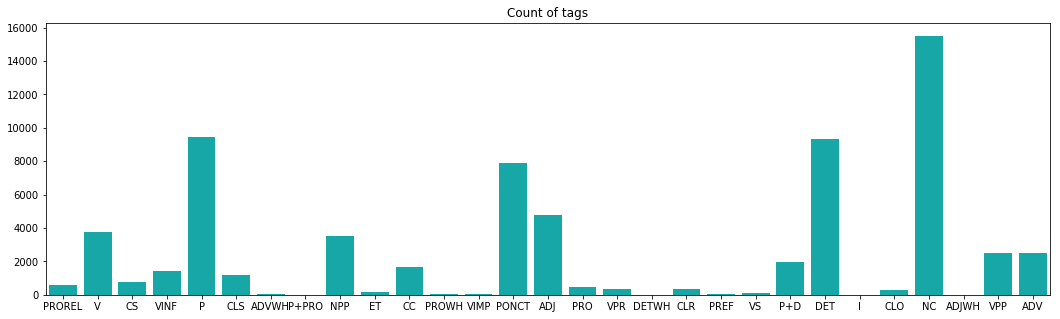

In [8]:
plt.subplots(figsize=(18,5))
sns.categorical.barplot(x=list(tags.keys()), y=list(tags.values()),color='c')
plt.title('Count of tags')

In [9]:
def text(t):
    text = []
    for i in t:
        text.append(i['form'])
    return re.sub('\' ','\'',' '.join(text))

In [10]:
text(sentences[3])

"Ensuite , fut installée une autre forge à la Vacquerie , à l'emplacement aujourd'hui de Cora ."

In [11]:
# train the NLTK POSTAGGER on the corpus
# create a tupple for every sentence such that (token, tag)
tag_sent = []
for item in sentences:
    sent = []
    for word in item:
        text = word['form']
        tag = word['upostag']
        sent.append((text,tag))
    tag_sent.append(sent)

In [12]:
#split to train and test sets
size = int(len(tag_sent) * 0.9)
train_sents = tag_sent[:size]
test_sents = tag_sent[size:]

In [13]:
# train Unigramtagger
unigram_tagger = nltk.UnigramTagger(train_sents)
unigram_tagger.evaluate(test_sents)

0.8034017775053631

In [14]:
#train a BigramTagger
Bigram_tagger = nltk.BigramTagger(train_sents)
Bigram_tagger.evaluate(test_sents)

0.16993564204719583

In [15]:
#train a Trigramtagger
Trigram_tagger = nltk.TrigramTagger(train_sents)
Trigram_tagger.evaluate(test_sents)

0.0959239963224027

In [16]:
#Ensemble the Uni and Bi - gram taggers
t1 = nltk.UnigramTagger(train_sents)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
t2.evaluate(test_sents)

0.8125957707631014

In [17]:
#Ensemble the Uni and Bi and Tri - gram taggers, the performance is slightly down, we stick with Uni and Bi -gram taggers
t3 = nltk.TrigramTagger(train_sents, backoff=t2)
t3.evaluate(test_sents)

0.8121360711002146

In [18]:
#prepare the curl command
import requests

token = ''

headers = {
    'Authorization': 'LettriaProKey %s'%token,
    'Content-Type': 'application/json',
}

In [19]:
# we create a list that have full sentence to send to Lettria api, and tupples of tokens to measure accuracy later (sentence, (tokens,tags))
# note, for this draft, no preprocessing of text is done. for example when there is the apostrophe like l'humain
# it will be: (l',humain). it could be interesting to investigate if there is a change in performance
sentences_ = []
for sent in test_sents:
    s = ' '.join(list(map(lambda x: x[0], sent)))
    sentences_.append((s,sent))



In [20]:
sentences_[1]

('- Février 2005 : le parquet de Paris requiert un non- lieu en faveur de Jean Tiberi , accordé par le juge Armand Riberolles .',
 [('-', 'PONCT'),
  ('Février', 'N'),
  ('2005', 'N'),
  (':', 'PONCT'),
  ('le', 'D'),
  ('parquet', 'N'),
  ('de', 'P'),
  ('Paris', 'N'),
  ('requiert', 'V'),
  ('un', 'D'),
  ('non-', 'PREF'),
  ('lieu', 'N'),
  ('en', 'P'),
  ('faveur', 'N'),
  ('de', 'P'),
  ('Jean', 'N'),
  ('Tiberi', 'N'),
  (',', 'PONCT'),
  ('accordé', 'V'),
  ('par', 'P'),
  ('le', 'D'),
  ('juge', 'N'),
  ('Armand', 'N'),
  ('Riberolles', 'N'),
  ('.', 'PONCT')])

In [21]:
# make Lettria text compliant sentence
testsent = '"' + sentences_[0][0] + '"'
data = '{ "text": %s }'%testsent
data

'{ "text": "- 19 janvier 2004 : le juge Armand Riberolles clôt ses investigations et l\' instruction de l\' affaire des HLM de Paris ." }'

In [22]:
response = requests.post('https://api.lettria.com/main', headers=headers, data=data)

In [23]:
# test response
response.json()

{'Entities_numeral': [],
 'NER': [{'meaning': ['Number'], 'source': '19', 'value': '19'},
  {'meaning': ['firstname', 'Mois'], 'source': 'janvier', 'value': None},
  {'meaning': ['Number'], 'source': '2004', 'value': '2004'},
  {'meaning': [], 'source': 'Armand', 'value': None},
  {'meaning': [], 'source': 'Riberolles', 'value': None},
  {'meaning': [], 'source': 'investigations', 'value': None},
  {'meaning': ['Documents'], 'source': 'instruction', 'value': None},
  {'meaning': [], 'source': 'affaire', 'value': None},
  {'meaning': ['Edifices'], 'source': 'HLM', 'value': None},
  {'meaning': ['Prefectures', 'firstname'], 'source': 'Paris', 'value': None}],
 'NLP': [{'source': '-', 'tag': 'PUNCT'},
  {'lemmatizer': {'confidence': '0.99', 'number': '19'},
   'source': '19',
   'tag': 'CD'},
  {'lemmatizer': {'confidence': '0.70',
    'gender': {'female': False, 'plural': False},
    'lemma': 'janvier'},
   'source': 'janvier',
   'tag': 'N'},
  {'lemmatizer': {'confidence': '0.99', 'num

In [24]:
r = response.json()['postagger']

In [25]:
for i,j in zip(r,sentences_[0][1]):
    print(i,j)

['-', 'PUNCT'] ('-', 'PONCT')
['19', 'CD'] ('19', 'A')
['janvier', 'N'] ('janvier', 'N')
['2004', 'CD'] ('2004', 'N')
[':', 'PUNCT'] (':', 'PONCT')
['le', 'D'] ('le', 'D')
['juge', 'JJ'] ('juge', 'N')
['Armand', 'NP'] ('Armand', 'N')
['Riberolles', 'NP'] ('Riberolles', 'N')
['cl�t', 'V'] ('clôt', 'V')
['ses', 'D'] ('ses', 'D')
['investigations', 'N'] ('investigations', 'N')
['et', 'CC'] ('et', 'C')
['le', 'D'] ("l'", 'D')
['instruction', 'N'] ('instruction', 'N')
['de', 'P'] ('de', 'P')
['le', 'D'] ("l'", 'D')
['affaire', 'N'] ('affaire', 'N')
['des', 'P'] ('des', 'P+D')
['HLM', 'NP'] ('HLM', 'N')
['de', 'P'] ('de', 'P')
['Paris', 'NP'] ('Paris', 'N')
['.', 'PUNCT'] ('.', 'PONCT')


In [26]:
#To compute accuracy for this sentence i assumed the following to be True:
# PUNCT == PONCT, NP == N, CC == C, P == P+D. The result is 20 correct tags with test_set
# The three only mistakes: two are on numbers, and one was on the word "juge"
print('Accuracy on the test sentence using Lettria tagger is {:.2f}%'.format(20/len(r)*100))

Accuracy on the test sentence using Lettria tagger is 86.96%


In [27]:
testsentntlk = testsent.split()
for i, j in zip(t3.tag(testsentntlk),sentences_[0][1]):
    print(i,j)

('"-', None) ('-', 'PONCT')
('19', 'A') ('19', 'A')
('janvier', 'N') ('janvier', 'N')
('2004', 'N') ('2004', 'N')
(':', 'PONCT') (':', 'PONCT')
('le', 'D') ('le', 'D')
('juge', 'N') ('juge', 'N')
('Armand', 'N') ('Armand', 'N')
('Riberolles', 'N') ('Riberolles', 'N')
('clôt', None) ('clôt', 'V')
('ses', 'D') ('ses', 'D')
('investigations', 'N') ('investigations', 'N')
('et', 'C') ('et', 'C')
("l'", 'D') ("l'", 'D')
('instruction', 'N') ('instruction', 'N')
('de', 'P') ('de', 'P')
("l'", 'D') ("l'", 'D')
('affaire', 'N') ('affaire', 'N')
('des', 'P+D') ('des', 'P+D')
('HLM', 'N') ('HLM', 'N')
('de', 'P') ('de', 'P')
('Paris', 'N') ('Paris', 'N')
('."', None) ('.', 'PONCT')


In [28]:
# The three only mistakes: two are on punctuations, and one was on the word "clôt"
print('Accuracy on the test sentence using NTLK tagger is {:.2f}%'.format(20/len(r)*100))

Accuracy on the test sentence using NTLK tagger is 86.96%


In [29]:
# More analysis to come